In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp
from scipy.integrate import odeint
import plotly.graph_objects as go
from IPython.display import HTML
from scipy.optimize import curve_fit

In [2]:
def convert_angle(angle):
    return np.mod(angle, 2*np.pi) * 180 / np.pi

def lin(x, a, b):
    return a * x + b 


def Get_frequency(t, angle, freq0, angle0):
    tab, pcov = curve_fit(lin, t, angle, p0 = [freq0, angle0])
    freq = tab[0] / (2 * np.pi)
    phi0 = tab[1]
    return freq, phi0

In [3]:
def Solve_Gyro_Forced(time, CI, params, omega_excitation, plot=True):
    t, h, g, m, x0, w = smp.symbols('t h g m x_0, w', real=True)
    the, phi, psi = smp.symbols(r'\theta \phi \psi', cls=smp.Function)
    the = the(t)
    phi = phi(t)
    psi = psi(t)
    # Derivatives
    the_d = smp.diff(the,t)
    phi_d = smp.diff(phi,t)
    psi_d = smp.diff(psi,t)
    # Second derivatives
    the_dd = smp.diff(the_d,t)
    phi_dd = smp.diff(phi_d,t)
    psi_dd = smp.diff(psi_d,t)
    R3 = smp.Matrix([[smp.cos(psi),-smp.sin(psi),0],
                 [smp.sin(psi),smp.cos(psi),0],
                 [0,0,1]])

    R2 = smp.Matrix([[1,0,0],
                     [0,smp.cos(the),-smp.sin(the)],
                     [0,smp.sin(the),smp.cos(the)]])
    
    R1 = smp.Matrix([[smp.cos(phi),-smp.sin(phi),0],
                     [smp.sin(phi),smp.cos(phi),0],
                     [0,0,1]])
    
    R = R1*R2*R3
    xc = h * R@smp.Matrix([0,0,1]) + smp.Matrix([x0 * smp.sin(w * t),0,0])
    vc = smp.diff(xc, t)
    vc_carre = vc.T.dot(vc).simplify()
    omega = smp.Matrix([phi_d*smp.sin(the)*smp.sin(psi)+the_d*smp.cos(psi),
                        phi_d*smp.sin(the)*smp.cos(psi)-the_d*smp.sin(psi),
                        phi_d*smp.cos(the)+psi_d])
    J1, J3 = smp.symbols('J_1, J_3', real=True)
    I = smp.Matrix([[J1,0,0],[0,J1,0],[0,0,J3]])
    T_rot = smp.Rational(1,2)*omega.T.dot(I*omega).simplify()
    T_c = smp.Rational(1,2) * m * vc_carre
    
    
    T = T_c + T_rot
    
    V = m*g*h*smp.cos(the)
    L = T-V
    L = L.simplify()
    LE1 = smp.diff(L, the) - smp.diff(smp.diff(L, the_d), t)
    LE1 = LE1.simplify()
    
    LE2 = smp.diff(L, phi) - smp.diff(smp.diff(L, phi_d), t)
    LE2 = LE2.simplify()
    
    LE3 = smp.diff(L, psi) - smp.diff(smp.diff(L, psi_d), t)
    LE3 = LE3.simplify()
    sols = smp.solve([LE1, LE2, LE3], (the_dd, phi_dd, psi_dd),
                    simplify=False, rational=False)
    dz1dt_f = smp.lambdify((t, g, h, m, x0, w, J1, J3,the,phi,psi,the_d,phi_d,psi_d), sols[the_dd])
    dthedt_f = smp.lambdify(the_d, the_d)
    
    dz2dt_f = smp.lambdify((t, g, h, m, x0, w, J1, J3,the,phi,psi,the_d,phi_d,psi_d), sols[phi_dd])
    dphidt_f = smp.lambdify(phi_d, phi_d)
    
    dz3dt_f = smp.lambdify((t, g, h, m, x0, w, J1, J3, the,phi,psi,the_d,phi_d,psi_d), sols[psi_dd])
    dpsidt_f = smp.lambdify(psi_d, psi_d)
    
    def dSdt(S, t):
        the, z1, phi, z2, psi, z3 = S
        return [
            dthedt_f(z1),
            dz1dt_f(t, g, h, m, x0, w, J1, J3,the,phi,psi,z1,z2,z3),
            dphidt_f(z2),
            dz2dt_f(t, g, h, m, x0, w, J1, J3,the,phi,psi,z1,z2,z3),
            dpsidt_f(z3),
            dz3dt_f(t, g, h, m, x0, w, J1, J3,the,phi,psi,z1,z2,z3),
        ]
    
    g, m, h, J1, J3, x0 = params ######### IMPORTANT

    w = omega_excitation
    
    t = time
    # Initial Condition 1
    ans = odeint(dSdt, y0=CI, t=t)

    path = 0
    
    the_t = ans.T[0]
    phi_t = ans.T[2]
    psi_t = ans.T[4]
    x_t = np.sin(phi_t)*np.sin(the_t)
    y_t = -np.cos(phi_t)*np.sin(the_t)
    z_t = np.cos(the_t)

    freq_precession, phi0 = Get_frequency(t, phi_t, 1, 0)
    freq_rotation, psi0 = Get_frequency(t, psi_t, CI[-1], 0)

    

    if plot:
        print('precession frequency =', freq_precession)
        print('rotation frequency =', freq_rotation)
        print(freq_rotation / freq_precession)
        print((J3 * (2*np.pi*freq_rotation)**2) / (m * g * h))
        plt.figure(figsize=[15,5])
        plt.subplot(1,2,1)
        plt.plot(t, the_t * 180 / np.pi)
        plt.ylabel(r'$\theta(t) \; (\mathrm{degrees})$')
        plt.xlabel(r'$t \; (\mathrm{s})$')

        plt.subplot(1,2,2)
        plt.plot(t, convert_angle(phi_t) )
        plt.ylabel(r'$\phi(t) \; (\mathrm{degrees})$')
        plt.xlabel(r'$t \; (\mathrm{s})$')
        plt.show()
 
        i = 0
        f= 1000000
        
        layout = go.Layout(title=r'Plot Title',
                             scene=dict(xaxis_title=r'x',
                                        yaxis_title=r'y',
                                        zaxis_title=r'z',
                                        aspectratio=dict(x=1, y=1, z=1),
                                        camera_eye=dict(x=1.2, y=1.2, z=1.2)))
        
        fig = go.Figure(layout=layout)
        fig.add_scatter3d(x=[0],y=[0],z=[0])
        fig.add_scatter3d(x=x_t[i:f],y=y_t[i:f],z=z_t[i:f], mode='lines',
                          line = dict(color='green', width=2))
        
        fig.update_layout(
            scene = dict(xaxis = dict(range=[-1,1],),
                         yaxis = dict(range=[-1,1],),
                         zaxis = dict(range=[-1,1],),))
        
        path = HTML(fig.to_html(default_width=1000, default_height=600))

        
    return the_t, phi_t, psi_t, x_t, y_t, z_t, path

In [4]:
def Solve_Gyro_Free(time, CI, params, plot=True):
    t, h, g, m = smp.symbols('t h g m', real=True)
    the, phi, psi = smp.symbols(r'\theta \phi \psi', cls=smp.Function)
    the = the(t)
    phi = phi(t)
    psi = psi(t)
    # Derivatives
    the_d = smp.diff(the,t)
    phi_d = smp.diff(phi,t)
    psi_d = smp.diff(psi,t)
    # Second derivatives
    the_dd = smp.diff(the_d,t)
    phi_dd = smp.diff(phi_d,t)
    psi_dd = smp.diff(psi_d,t)
    R3 = smp.Matrix([[smp.cos(psi),-smp.sin(psi),0],
                 [smp.sin(psi),smp.cos(psi),0],
                 [0,0,1]])

    R2 = smp.Matrix([[1,0,0],
                     [0,smp.cos(the),-smp.sin(the)],
                     [0,smp.sin(the),smp.cos(the)]])
    
    R1 = smp.Matrix([[smp.cos(phi),-smp.sin(phi),0],
                     [smp.sin(phi),smp.cos(phi),0],
                     [0,0,1]])
    
    R = R1*R2*R3
    xc = h * R@smp.Matrix([0,0,1])
    vc = smp.diff(xc, t)
    vc_carre = vc.T.dot(vc).simplify()
    omega = smp.Matrix([phi_d*smp.sin(the)*smp.sin(psi)+the_d*smp.cos(psi),
                        phi_d*smp.sin(the)*smp.cos(psi)-the_d*smp.sin(psi),
                        phi_d*smp.cos(the)+psi_d])
    J1, J3 = smp.symbols('J_1, J_3', real=True)
    I = smp.Matrix([[J1,0,0],[0,J1,0],[0,0,J3]])
    T_rot = smp.Rational(1,2)*omega.T.dot(I*omega).simplify()
    T_c = smp.Rational(1,2) * m * vc_carre
    
    
    T = T_c + T_rot
    
    V = m*g*h*smp.cos(the)
    L = T-V
    L = L.simplify()
    LE1 = smp.diff(L, the) - smp.diff(smp.diff(L, the_d), t)
    LE1 = LE1.simplify()
    
    LE2 = smp.diff(L, phi) - smp.diff(smp.diff(L, phi_d), t)
    LE2 = LE2.simplify()
    
    LE3 = smp.diff(L, psi) - smp.diff(smp.diff(L, psi_d), t)
    LE3 = LE3.simplify()
    sols = smp.solve([LE1, LE2, LE3], (the_dd, phi_dd, psi_dd),
                    simplify=False, rational=False)
    dz1dt_f = smp.lambdify((g, h, m, J1, J3,the,phi,psi,the_d,phi_d,psi_d), sols[the_dd])
    dthedt_f = smp.lambdify(the_d, the_d)
    
    dz2dt_f = smp.lambdify((g, h, m, J1, J3,the,phi,psi,the_d,phi_d,psi_d), sols[phi_dd])
    dphidt_f = smp.lambdify(phi_d, phi_d)
    
    dz3dt_f = smp.lambdify((g, h, m, J1, J3, the,phi,psi,the_d,phi_d,psi_d), sols[psi_dd])
    dpsidt_f = smp.lambdify(psi_d, psi_d)
    
    def dSdt(S, t):
        the, z1, phi, z2, psi, z3 = S
        return [
            dthedt_f(z1),
            dz1dt_f(g, h, m, J1, J3,the,phi,psi,z1,z2,z3),
            dphidt_f(z2),
            dz2dt_f(g, h, m, J1, J3,the,phi,psi,z1,z2,z3),
            dpsidt_f(z3),
            dz3dt_f(g, h, m, J1, J3,the,phi,psi,z1,z2,z3),
        ]
    
    g, m, h, J1, J3 = params ######### IMPORTANT


    t = time
    # Initial Condition 1
    ans = odeint(dSdt, y0=CI, t=t)
    
    path = 0
    
    the_t = ans.T[0]
    phi_t = ans.T[2]
    psi_t = ans.T[4]
    x_t = np.sin(phi_t)*np.sin(the_t)
    y_t = -np.cos(phi_t)*np.sin(the_t)
    z_t = np.cos(the_t)

    

    if plot:
        freq_precession, phi0 = Get_frequency(t, phi_t, 1, 0)
        freq_rotation, psi0 = Get_frequency(t, psi_t, CI[-1], 0)
    
        print('precession frequency =', freq_precession)
        print('rotation frequency =', freq_rotation)
        print(freq_rotation / freq_precession)
        print((J3 * (2*np.pi*freq_rotation)**2) / (m * g * h))
        
        plt.figure(figsize=[15,5])
        plt.subplot(1,2,1)
        plt.plot(t, the_t * 180 / np.pi)
        plt.ylabel(r'$\theta(t) \; (\mathrm{degrees})$')
        plt.xlabel(r'$t \; (\mathrm{s})$')

        plt.subplot(1,2,2)
        plt.plot(t, convert_angle(phi_t) )
        plt.ylabel(r'$\phi(t) \; (\mathrm{degrees})$')
        plt.xlabel(r'$t \; (\mathrm{s})$')
        plt.show()


        i = 0
        f= 1000000
        
        layout = go.Layout(title=r'Plot Title',
                             scene=dict(xaxis_title=r'x',
                                        yaxis_title=r'y',
                                        zaxis_title=r'z',
                                        aspectratio=dict(x=1, y=1, z=1),
                                        camera_eye=dict(x=1.2, y=1.2, z=1.2)))
        
        fig = go.Figure(layout=layout)
        fig.add_scatter3d(x=[0],y=[0],z=[0])
        fig.add_scatter3d(x=x_t[i:f],y=y_t[i:f],z=z_t[i:f], mode='lines',
                          line = dict(color='green', width=2))
        
        fig.update_layout(
            scene = dict(xaxis = dict(range=[-1,1],),
                         yaxis = dict(range=[-1,1],),
                         zaxis = dict(range=[-1,1],),))
        
        path = HTML(fig.to_html(default_width=1000, default_height=600))

        
    return the_t, phi_t, psi_t, x_t, y_t, z_t, path

0.5294535572787643
precession frequency = 0.5489104568961073
rotation frequency = 99.53419758293488
181.33048174335252
187.11851780537805


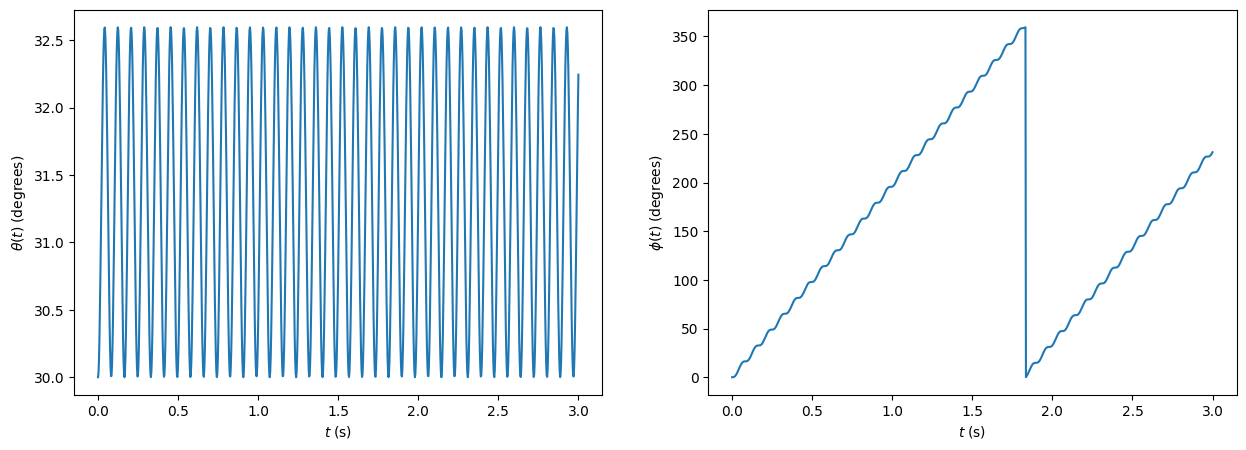

In [5]:
CI = [np.pi/6, 0, 0, 0, 0, 2*np.pi*100]

t = np.linspace(0, 3, 1000)

g_ = 9.81
r = 53 / 2 * 1e-3
e = 12 * 1e-3
m_ = 0.375
#J3_ = m_ * (r**2) / 2
#J1_ = J3_ + m_ * e**2 / 12
J3_ = 0.000055
J1_ = 0.000055
h_ = 31.25 * 1e-3

larmor_frequency = ((m_ * g_ * h_) / (J3_ * 2*np.pi * 100)) / (2 * np.pi)

print(larmor_frequency)

params_lib = [g_, m_, h_, J1_, J3_]

the_t_lib, phi_t_lib, psi_t_lib, x_t_lib, y_t_lib, z_t_lib, path_lib = Solve_Gyro_Free(t, CI, params_lib)

precession frequency = 0.5200354211134148
rotation frequency = 100.23931388387683
192.75478133635744
189.7790639004059


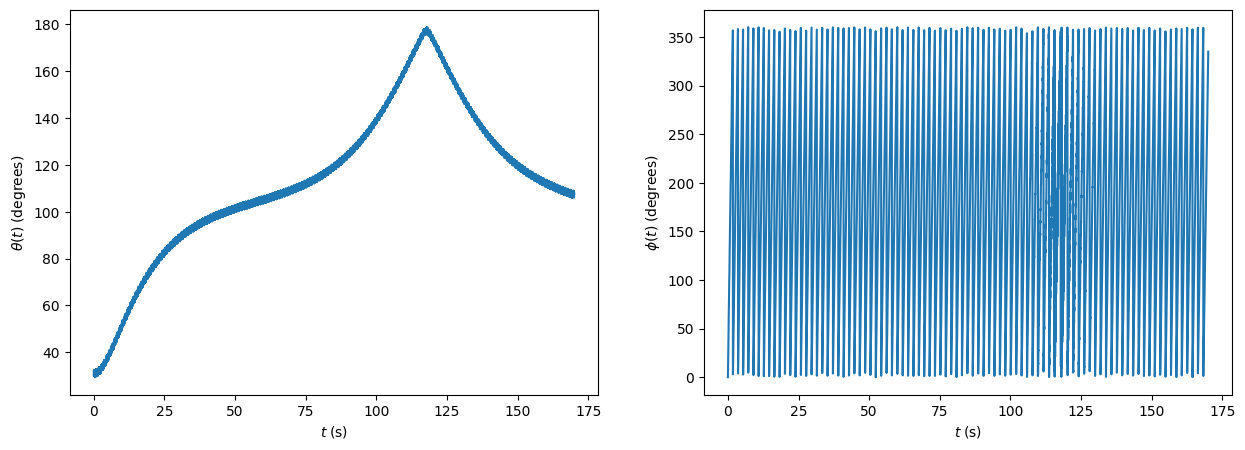

3.1207795461501378

In [7]:
x0_ = 2.5 * 1e-2

t = np.linspace(0, 170, 10000)

params_f = [g_, m_, h_, J1_, J3_, x0_]

# omega_f = 2 * np.pi * 0.52589

omega_f = 2 * np.pi * 0.52589

the_t_f, phi_t_f, psi_t_f, x_t_f, y_t_f, z_t_f, path_f = Solve_Gyro_Forced(t, CI, params_f, omega_excitation=omega_f)
np.max(the_t_f)

In [8]:
i = 0
f= 100000

layout = go.Layout(title=r'Plot Title',
                     scene=dict(xaxis_title=r'x',
                                yaxis_title=r'y',
                                zaxis_title=r'z',
                                aspectratio=dict(x=1, y=1, z=1),
                                camera_eye=dict(x=1.2, y=1.2, z=1.2)))

fig = go.Figure(layout=layout)
fig.add_scatter3d(x=[0],y=[0],z=[0])
fig.add_scatter3d(x=x_t_f[i:f],y=y_t_f[i:f],z=z_t_f[i:f], mode='lines',
                  line = dict(color='green', width=5))

fig.update_layout(
    scene = dict(xaxis = dict(range=[-1,1],),
                 yaxis = dict(range=[-1,1],),
                 zaxis = dict(range=[-1,1],),))

HTML(fig.to_html(default_width=1000, default_height=600))

In [18]:
def Get_max_theta(omega):
    the_t_f, phi_t_f, psi_t_f, x_t_f, y_t_f, z_t_f, path_f = Solve_Gyro_Forced(t, CI, params_f, omega_excitation=omega, plot=False)
    return np.max(the_t_f)

def Chevrons_Rabi(omega, omega_precession):
    
    delta = omega - omega_precession
    tab_theta = []
    
    for i in range(len(omega)):
        tab_theta.append(Get_max_theta(omega[i]))
    tab_theta = np.array(tab_theta)
    plt.figure()
    plt.scatter(delta, tab_theta * 180 / np.pi)
    plt.ylabel(r'$\theta_\mathrm{max} \; (^\circ)$')
    plt.xlabel(r'$\delta = \omega - \omega_L \; (\mathrm{Hz})$')

    return tab_theta


In [14]:
omega_balayage = np.linspace( 2 * np.pi * 0.525, 2 * np.pi * 0.55, 5, endpoint=True)
omega_L_balayage = 2 * np.pi * 0.52589
len(omega_balayage)

5

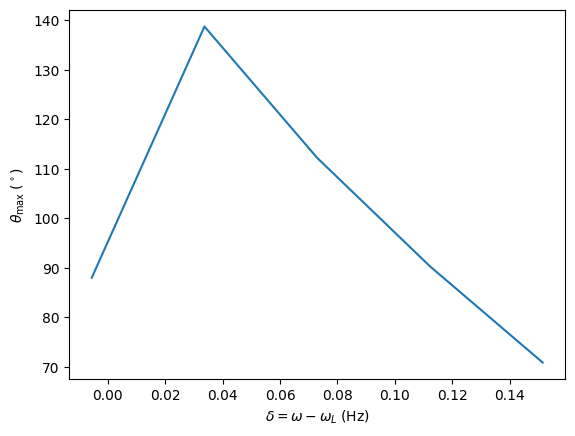

In [15]:
theta_balayage = Chevrons_Rabi(omega_balayage, omega_L_balayage)

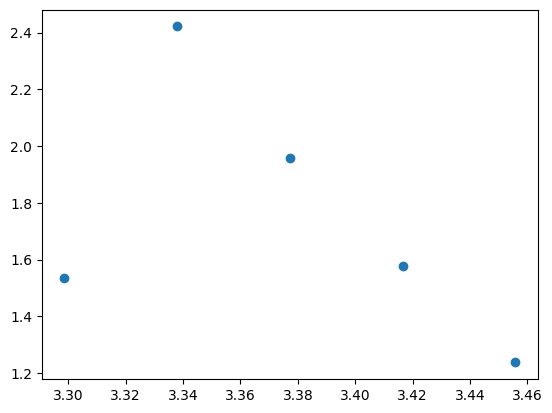

In [17]:
plt.figure()
plt.scatter(omega_balayage, theta_balayage)

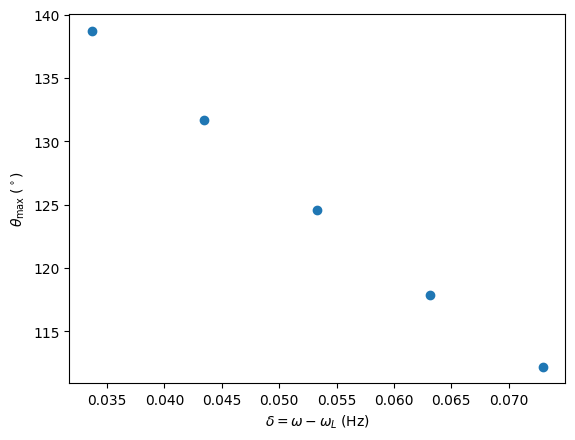

In [19]:
omega_b_2 = np.linspace(omega_balayage[1], omega_balayage[2], 5, endpoint=True)
theta_b_2 = Chevrons_Rabi(omega_b_2, omega_L_balayage)

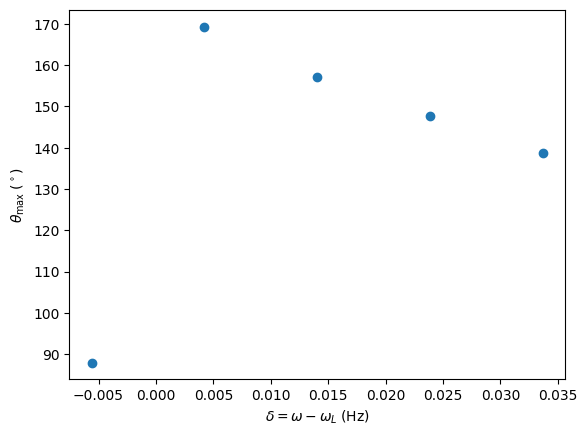

In [20]:
omega_b_2 = np.linspace(omega_balayage[0], omega_balayage[1], 5, endpoint=True)
theta_b_2 = Chevrons_Rabi(omega_b_2, omega_L_balayage)

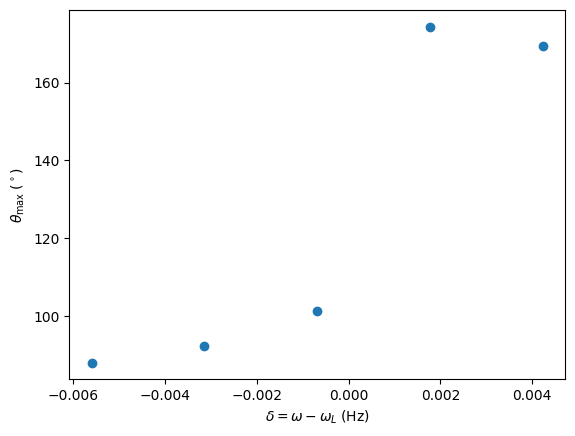

In [21]:
omega_b_3 = np.linspace(omega_b_2[0], omega_b_2[1], 5, endpoint=True)
theta_b_3 = Chevrons_Rabi(omega_b_3, omega_L_balayage)

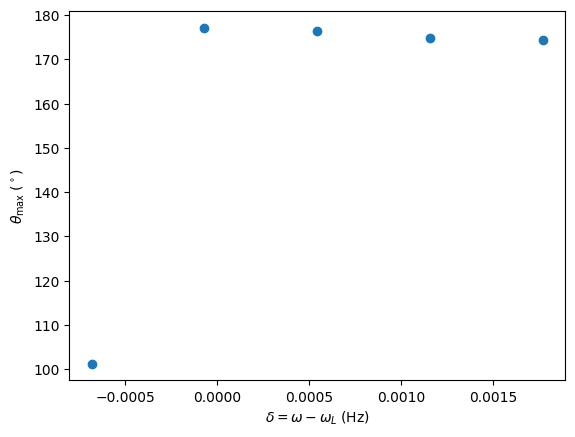

In [23]:
omega_b_4 = np.linspace(omega_b_3[-3], omega_b_3[-2], 5, endpoint=True)
theta_b_4 = Chevrons_Rabi(omega_b_4, omega_L_balayage)

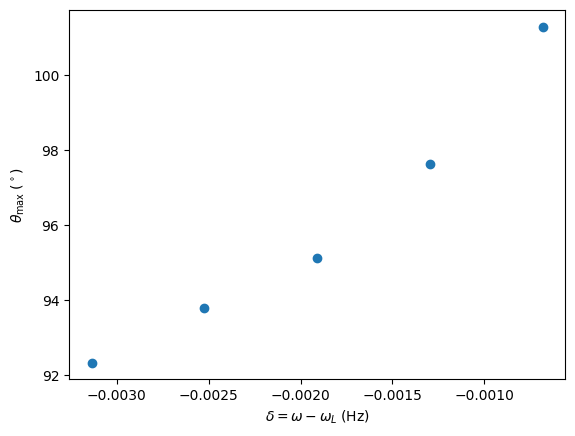

In [24]:
omega_b_5 = np.linspace(omega_b_4[0], omega_b_3[1], 5, endpoint=True)
theta_b_5 = Chevrons_Rabi(omega_b_5, omega_L_balayage)